In [1]:
# This is a copy of the frozen lake environment found in C:\Users\<username>\.conda\envs\gymenv\Lib\site-packages\gymnasium\envs\toy_text\frozen_lake.py
# The environment has been enhanced with Q values overlayed on top of the map plus shortcut keys to speed up/slow down the animation.

from contextlib import closing
from io import StringIO
from os import path
from typing import List, Optional

import numpy as np

import gymnasium as gym
from gymnasium import Env, spaces, utils
from gymnasium.envs.toy_text.utils import categorical_sample
from gymnasium.error import DependencyNotInstalled
from gymnasium.utils import seeding

import pygame

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

MAPS = {
    "4x4": ["SFFF", "FHFH", "FFFH", "HFFG"],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG",
    ],
}


# DFS to check that it's a valid path.
def is_valid(board: List[List[str]], max_size: int) -> bool:
    frontier, discovered = [], set()
    frontier.append((0, 0))
    while frontier:
        r, c = frontier.pop()
        if not (r, c) in discovered:
            discovered.add((r, c))
            directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
            for x, y in directions:
                r_new = r + x
                c_new = c + y
                if r_new < 0 or r_new >= max_size or c_new < 0 or c_new >= max_size:
                    continue
                if board[r_new][c_new] == "G":
                    return True
                if board[r_new][c_new] != "H":
                    frontier.append((r_new, c_new))
    return False


def generate_random_map(
    size: int = 8, p: float = 0.8, seed: Optional[int] = None
) -> List[str]:
    """Generates a random valid map (one that has a path from start to goal)

    Args:
        size: size of each side of the grid
        p: probability that a tile is frozen
        seed: optional seed to ensure the generation of reproducible maps

    Returns:
        A random valid map
    """
    valid = False
    board = []  # initialize to make pyright happy

    np_random, _ = seeding.np_random(seed)

    while not valid:
        p = min(1, p)
        board = np_random.choice(["F", "H"], (size, size), p=[p, 1 - p])
        board[0][0] = "S"
        board[-1][-1] = "G"
        valid = is_valid(board, size)
    return ["".join(x) for x in board]


class FrozenLakeEnv(Env):
    """
    Frozen lake involves crossing a frozen lake from start to goal without falling into any holes
    by walking over the frozen lake.
    The player may not always move in the intended direction due to the slippery nature of the frozen lake.

    ## Description
    The game starts with the player at location [0,0] of the frozen lake grid world with the
    goal located at far extent of the world e.g. [3,3] for the 4x4 environment.

    Holes in the ice are distributed in set locations when using a pre-determined map
    or in random locations when a random map is generated.

    The player makes moves until they reach the goal or fall in a hole.

    The lake is slippery (unless disabled) so the player may move perpendicular
    to the intended direction sometimes (see <a href="#is_slippy">`is_slippery`</a>).

    Randomly generated worlds will always have a path to the goal.

    Elf and stool from [https://franuka.itch.io/rpg-snow-tileset](https://franuka.itch.io/rpg-snow-tileset).
    All other assets by Mel Tillery [http://www.cyaneus.com/](http://www.cyaneus.com/).

    ## Action Space
    The action shape is `(1,)` in the range `{0, 3}` indicating
    which direction to move the player.

    - 0: Move left
    - 1: Move down
    - 2: Move right
    - 3: Move up

    ## Observation Space
    The observation is a value representing the player's current position as
    current_row * nrows + current_col (where both the row and col start at 0).

    For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15.
    The number of possible observations is dependent on the size of the map.

    The observation is returned as an `int()`.

    ## Starting State
    The episode starts with the player in state `[0]` (location [0, 0]).

    ## Rewards

    Reward schedule:
    - Reach goal: +1
    - Reach hole: 0
    - Reach frozen: 0

    ## Episode End
    The episode ends if the following happens:

    - Termination:
        1. The player moves into a hole.
        2. The player reaches the goal at `max(nrow) * max(ncol) - 1` (location `[max(nrow)-1, max(ncol)-1]`).

    - Truncation (when using the time_limit wrapper):
        1. The length of the episode is 100 for 4x4 environment, 200 for 8x8 environment.

    ## Information

    `step()` and `reset()` return a dict with the following keys:
    - p - transition probability for the state.

    See <a href="#is_slippy">`is_slippery`</a> for transition probability information.


    ## Arguments

    ```python
    import gymnasium as gym
    gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
    ```

    `desc=None`: Used to specify maps non-preloaded maps.

    Specify a custom map.
    ```
        desc=["SFFF", "FHFH", "FFFH", "HFFG"].
    ```

    A random generated map can be specified by calling the function `generate_random_map`.
    ```
    from gymnasium.envs.toy_text.frozen_lake import generate_random_map

    gym.make('FrozenLake-v1', desc=generate_random_map(size=8))
    ```

    `map_name="4x4"`: ID to use any of the preloaded maps.
    ```
        "4x4":[
            "SFFF",
            "FHFH",
            "FFFH",
            "HFFG"
            ]

        "8x8": [
            "SFFFFFFF",
            "FFFFFFFF",
            "FFFHFFFF",
            "FFFFFHFF",
            "FFFHFFFF",
            "FHHFFFHF",
            "FHFFHFHF",
            "FFFHFFFG",
        ]
    ```

    If `desc=None` then `map_name` will be used. If both `desc` and `map_name` are
    `None` a random 8x8 map with 80% of locations frozen will be generated.

    <a id="is_slippy"></a>`is_slippery=True`: If true the player will move in intended direction with
    probability of 1/3 else will move in either perpendicular direction with
    equal probability of 1/3 in both directions.

    For example, if action is left and is_slippery is True, then:
    - P(move left)=1/3
    - P(move up)=1/3
    - P(move down)=1/3


    ## Version History
    * v1: Bug fixes to rewards
    * v0: Initial version release

    """

    metadata = {
        "render_modes": ["human", "ansi", "rgb_array"],
        "render_fps": 4,
    }

    def __init__(
        self,
        render_mode: Optional[str] = None,
        desc=None,
        map_name="4x4",
        is_slippery=True,
    ):
        if desc is None and map_name is None:
            desc = generate_random_map()
        elif desc is None:
            desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc, dtype="c")
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)

        nA = 4
        nS = nrow * ncol

        self.initial_state_distrib = np.array(desc == b"S").astype("float64").ravel()
        self.initial_state_distrib /= self.initial_state_distrib.sum()

        self.P = {s: {a: [] for a in range(nA)} for s in range(nS)}

        def to_s(row, col):
            return row * ncol + col

        def inc(row, col, a):
            if a == LEFT:
                col = max(col - 1, 0)
            elif a == DOWN:
                row = min(row + 1, nrow - 1)
            elif a == RIGHT:
                col = min(col + 1, ncol - 1)
            elif a == UP:
                row = max(row - 1, 0)
            return (row, col)

        def update_probability_matrix(row, col, action):
            newrow, newcol = inc(row, col, action)
            newstate = to_s(newrow, newcol)
            newletter = desc[newrow, newcol]
            terminated = bytes(newletter) in b"GH"
            reward = float(newletter == b"G")
            return newstate, reward, terminated

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = self.P[s][a]
                    letter = desc[row, col]
                    if letter in b"GH":
                        li.append((1.0, s, 0, True))
                    else:
                        if is_slippery:
                            for b in [(a - 1) % 4, a, (a + 1) % 4]:
                                li.append(
                                    (1.0 / 3.0, *update_probability_matrix(row, col, b))
                                )
                        else:
                            li.append((1.0, *update_probability_matrix(row, col, a)))

        self.observation_space = spaces.Discrete(nS)
        self.action_space = spaces.Discrete(nA)

        self.render_mode = render_mode

        # pygame utils
        self.window_size = (min(64 * ncol, 512), min(64 * nrow, 512))
        self.cell_size = (
            self.window_size[0] // self.ncol,
            self.window_size[1] // self.nrow,
        )
        self.window_surface = None
        self.clock = None
        self.hole_img = None
        self.cracked_hole_img = None
        self.ice_img = None
        self.elf_images = None
        self.goal_img = None
        self.start_img = None

        # Additional variables
        self.q_table = None
        self.episode = '---'
        self.pygame_initialized = False    # flag to determine if pygame has been initialized
        self.text_padding = 5

    def step(self, a):
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        p, s, r, t = transitions[i]
        self.s = s
        self.lastaction = a

        if self.pygame_initialized:
            # Process user events, key presses
            for event in pygame.event.get():
                if(event.type == pygame.KEYDOWN):
                    # quit game
                    if(event.key == pygame.K_ESCAPE):
                        pygame.quit()
                        import sys;
                        sys.exit()
                    # increase animation speed
                    elif(event.key == pygame.K_EQUALS):
                        self.metadata["render_fps"]+=10
                    # decrease animation speed
                    elif(event.key == pygame.K_MINUS):
                        self.metadata["render_fps"]-=10
                        if(self.metadata["render_fps"]<=0):
                            self.metadata["render_fps"]=1
                    # fastest animation speed. 0 is Unlimited fps
                    elif(event.key == pygame.K_0):
                        self.metadata["render_fps"]=0
                    # reset to original fps
                    elif(event.key == pygame.K_1):
                        self.metadata["render_fps"]=4
                    # toggle rendering. Turn off rendering to speed up training.
                    elif(event.key == pygame.K_9):
                        self.render_mode=None if(self.render_mode=="human") else "human"

        if self.render_mode == "human":
            self.render()
        return (int(s), r, t, False, {"prob": p})

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self.s = categorical_sample(self.initial_state_distrib, self.np_random)
        self.lastaction = None

        if self.render_mode == "human":
            self.render()
        return int(self.s), {"prob": 1}

    def render(self):
        if self.render_mode is None:
            assert self.spec is not None
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym.make("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        if self.render_mode == "ansi":
            return self._render_text()
        else:  # self.render_mode in {"human", "rgb_array"}:
            return self._render_gui(self.render_mode)

    def _render_gui(self, mode):
        try:
            import pygame
        except ImportError as e:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gymnasium[toy-text]`"
            ) from e

        if self.window_surface is None:
            pygame.init()
            self.pygame_initialized = True

            # fonts for UI
            self.ui_font = pygame.font.SysFont("Courier",25)
            self.ui_font_bold = pygame.font.SysFont("Courier",25,True)
            self.q_font = pygame.font.SysFont("Courier",11)
            self.q_font_bold = pygame.font.SysFont("Courier",11,True)

            if mode == "human":
                pygame.display.init()
                pygame.display.set_caption("Frozen Lake")
                # self.window_surface = pygame.display.set_mode(self.window_size)

                self.window_surface = pygame.display.set_mode(flags=pygame.FULLSCREEN)
                self.display_width, display_height = pygame.display.get_surface().get_size()

                # size of froze lake grid is the determined by the smaller of the display height vs width
                self.grid_size = display_height
                if self.grid_size > self.display_width:
                    self.grid_size = self.display_width

                self.window_size = (self.grid_size, self.grid_size)
                self.cell_size = (
                    self.window_size[0] // self.ncol,
                    self.window_size[1] // self.nrow,
                )
            elif mode == "rgb_array":
                self.window_surface = pygame.Surface(self.window_size)

        assert (
            self.window_surface is not None
        ), "Something went wrong with pygame. This should never happen."


        if self.clock is None:
            self.clock = pygame.time.Clock()
        if self.hole_img is None:
            file_name = path.join(path.dirname(__file__), "img/hole.png")
            self.hole_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.cracked_hole_img is None:
            file_name = path.join(path.dirname(__file__), "img/cracked_hole.png")
            self.cracked_hole_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.ice_img is None:
            file_name = path.join(path.dirname(__file__), "img/ice.png")
            self.ice_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.goal_img is None:
            file_name = path.join(path.dirname(__file__), "img/goal.png")
            self.goal_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.start_img is None:
            file_name = path.join(path.dirname(__file__), "img/stool.png")
            self.start_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.elf_images is None:
            elfs = [
                path.join(path.dirname(__file__), "img/elf_left.png"),
                path.join(path.dirname(__file__), "img/elf_down.png"),
                path.join(path.dirname(__file__), "img/elf_right.png"),
                path.join(path.dirname(__file__), "img/elf_up.png"),
            ]
            self.elf_images = [
                pygame.transform.scale(pygame.image.load(f_name), self.cell_size)
                for f_name in elfs
            ]

        # clear to white background, otherwise text with varying length will leave behind prior rendered portions
        self.window_surface.fill((255,255,255))

        desc = self.desc.tolist()
        assert isinstance(desc, list), f"desc should be a list or an array, got {desc}"
        for y in range(self.nrow):
            for x in range(self.ncol):
                pos = (x * self.cell_size[0], y * self.cell_size[1])
                rect = (*pos, *self.cell_size)

                self.window_surface.blit(self.ice_img, pos)
                if desc[y][x] == b"H":
                    self.window_surface.blit(self.hole_img, pos)
                elif desc[y][x] == b"G":
                    self.window_surface.blit(self.goal_img, pos)
                elif desc[y][x] == b"S":
                    self.window_surface.blit(self.start_img, pos)

                pygame.draw.rect(self.window_surface, (180, 200, 230), rect, 1)



                # render q values
                if(self.q_table is not None):

                    # map x y location to q table state
                    state = self.nrow * y + x

                    # Get index of max Q value
                    max_q_idx = np.argmax(self.q_table[state])
                    # If max Q value is 0, it hasn't receive learning yet, ignore
                    if(self.q_table[state][max_q_idx]==0):
                        max_q_idx = -1



                    # Calculate position of Q values within a cell to be displayed.
                    # Create a dummy render of a q value to help with positioning calculation.
                    q_img = self.q_font.render(".0000", True, (0,0,0), (255,255,255))
                    q_img_x = q_img.get_width()
                    q_img_y = q_img.get_height()
                    q_pos = [
                        (pos[0]+self.text_padding,
                            pos[1]+self.cell_size[1]/2), # left
                        (pos[0]+self.cell_size[0]/2-q_img_x/2,
                            pos[1]+self.cell_size[1] - self.text_padding - q_img_y), # bottom
                        (pos[0]+self.cell_size[0]-self.text_padding-q_img_x,
                            pos[1]+self.cell_size[1]/2), # right
                        (pos[0]+self.cell_size[0]/2-q_img_x/2,
                            pos[1]+self.text_padding), # top
                    ]

                    # Loop thru the 4 Q values for the current state
                    for i in range(4):
                        # Format q for display
                        q = '{:.4f}'.format(self.q_table[state][i]).lstrip('0')

                        if(max_q_idx == i):
                            # Render q in bold font. Render takes (value, antialias, color, background color)
                            q_img = self.q_font_bold.render(q, True, (0,0,0), (255,255,255))
                        else:
                            # Render q in regular font
                            q_img = self.q_font.render(q, True, (0,0,0), (255,255,255))

                        # Display text img at position
                        self.window_surface.blit(q_img, q_pos[i])


        # paint the elf
        bot_row, bot_col = self.s // self.ncol, self.s % self.ncol
        cell_rect = (bot_col * self.cell_size[0], bot_row * self.cell_size[1])
        last_action = self.lastaction if self.lastaction is not None else 1
        elf_img = self.elf_images[last_action]

        if desc[bot_row][bot_col] == b"H":
            self.window_surface.blit(self.cracked_hole_img, cell_rect)
        else:
            self.window_surface.blit(elf_img, cell_rect)

        if mode == "human":

            # render actual FPS
            text_img = self.ui_font.render(str(int(self.clock.get_fps()))+"fps", True, (0,0,0), (255,255,255))
            text_pos = (self.display_width - text_img.get_width() - self.text_padding, 0 + self.text_padding)
            self.window_surface.blit(text_img, text_pos)

            # render episodes
            text_img = self.ui_font.render("Episode: " + str(self.episode), True, (0,0,0), (255,255,255))
            text_pos = (self.grid_size + self.text_padding, self.text_padding)
            self.window_surface.blit(text_img, text_pos)

            # render shortcut keys
            text_lines = ["Shortcuts (Number Row)",                          
                          "1 : Reset FPS",
                          "0 : Unlimited FPS",
                          "- : Decrease FPS",
                          "= : Increase FPS",
                          "9 : Toggle Screen Update",
                          "Training continues in background",
                          "Window closes when training completes",
                          " ",
                          "ESC to Quit",
                          "Training progress is lost",
            ]

            starting_y = text_img.get_height() + text_img.get_height()
            text_line_height = text_img.get_height()
            for i, line in enumerate(text_lines):
                text_img = self.ui_font.render(line, True, (0,0,0), (255,255,255))
                text_pos = (self.grid_size + self.text_padding, starting_y + i*text_line_height + self.text_padding)
                self.window_surface.blit(text_img, text_pos)

            pygame.event.pump()
            pygame.display.update()
            self.clock.tick(self.metadata["render_fps"])
        elif mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.window_surface)), axes=(1, 0, 2)
            )

    @staticmethod
    def _center_small_rect(big_rect, small_dims):
        offset_w = (big_rect[2] - small_dims[0]) / 2
        offset_h = (big_rect[3] - small_dims[1]) / 2
        return (
            big_rect[0] + offset_w,
            big_rect[1] + offset_h,
        )

    def _render_text(self):
        desc = self.desc.tolist()
        outfile = StringIO()

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = [[c.decode("utf-8") for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write(f"  ({['Left', 'Down', 'Right', 'Up'][self.lastaction]})\n")
        else:
            outfile.write("\n")
        outfile.write("\n".join("".join(line) for line in desc) + "\n")

        with closing(outfile):
            return outfile.getvalue()

    def close(self):
        if self.window_surface is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()


# Elf and stool from https://franuka.itch.io/rpg-snow-tileset
# All other assets by Mel Tillery http://www.cyaneus.com/

    # pass in q
    def set_q(self, q_table):
        self.q_table = q_table

    def set_episode(self, episode):
        self.episode = episode

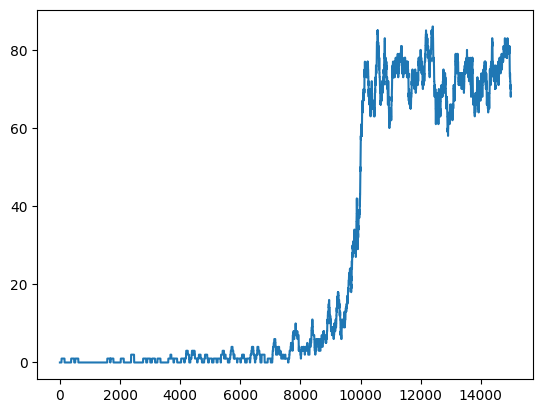

In [2]:
# This file is almost identical to frozen_lake_q.py, except this uses the frozen_lake_enhanced.py environment.

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Register the enhanced frozen lake environment
# Sample of registration entry found in C:\Users\<username>\.conda\envs\gymenv\Lib\site-packages\gymnasium\envs\__init__.py
gym.register(
    id="FrozenLake-enhanced", # give it a unique id
    entry_point="frozen_lake_enhanced:FrozenLakeEnv", # frozen_lake_enhanced = name of file 'frozen_lake_enhanced.py'
    kwargs={"map_name": "8x8"},
    max_episode_steps=200,
    reward_threshold=0.85,  # optimum = 0.91
)

def run(episodes, is_training=True, render=False):

    # 'FrozenLake-enhanced' is the id specified above
    env = gym.make('FrozenLake-enhanced', desc=None, map_name="8x8", is_slippery=True, render_mode='human' if render else None)

    if(is_training):
        q = np.zeros((env.observation_space.n, env.action_space.n)) # init a 64 x 4 array
    else:
        f = open('frozen_lake8x8.pkl', 'rb')
        q = pickle.load(f)
        f.close()

    learning_rate_a = 0.9 # alpha or learning rate
    discount_factor_g = 0.9 # gamma or discount rate. Near 0: more weight/reward placed on immediate state. Near 1: more on future state.
    epsilon = 1         # 1 = 100% random actions
    epsilon_decay_rate = 0.0001        # epsilon decay rate. 1/0.0001 = 10,000
    rng = np.random.default_rng()   # random number generator

    rewards_per_episode = np.zeros(episodes)

    for i in range(episodes):
        state = env.reset()[0]  # states: 0 to 63, 0=top left corner,63=bottom right corner
        terminated = False      # True when fall in hole or reached goal
        truncated = False       # True when actions > 200

        while(not terminated and not truncated):
            if is_training and rng.random() < epsilon:
                action = env.action_space.sample() # actions: 0=left,1=down,2=right,3=up
            else:
                action = np.argmax(q[state,:])

            new_state,reward,terminated,truncated,_ = env.step(action)

            if is_training:
                q[state,action] = q[state,action] + learning_rate_a * (
                    reward + discount_factor_g * np.max(q[new_state,:]) - q[state,action]
                )

            # pass the q table and episode count to the environment for rendering
            if(env.render_mode=='human'):
                env.set_q(q)
                env.set_episode(i)

            state = new_state

        epsilon = max(epsilon - epsilon_decay_rate, 0)

        if(epsilon==0):
            learning_rate_a = 0.0001

        if reward == 1:
            rewards_per_episode[i] = 1

    env.close()

    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])
    plt.plot(sum_rewards)
    plt.savefig('frozen_lake8x8.png')

    if is_training:
        f = open("frozen_lake8x8.pkl","wb")
        pickle.dump(q, f)
        f.close()

if __name__ == '__main__':

    run(15000, is_training=True, render=False)